# Email Classification: Building Blocks

## Env set up

In [0]:
!python3 --version

Python 3.12.3


In [0]:
%pip install -U -qqqq langgraph langgraph-prebuilt langgraph-sdk langgraph-checkpoint-sqlite langsmith langchain-community langchain-core langchain-openai notebook langchain-tavily wikipedia trustcall langgraph-cli[inmem] transformers

%pip install -U -qqqq databricks-agents mlflow-skinny[databricks] databricks-langchain
dbutils.library.restartPython()

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 2.20.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0.dev0,>=3.19.5, but you have protobuf 6.33.3 which is incompatible.
grpcio-status 1.67.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 6.33.3 which is incompatible.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-health-checking 1.76.0 requires protobuf<7.0.0,>=6.31.1, but you have protobuf 5.29.5 which is incompatible.
grpcio-tools 1.75.1 requires protobuf<7.0.0,>=6.31.1, but you have protobuf 5.29.5 which is incompatible.
langgraph-a

## Example data

In [0]:
## Creating a dataframe with examples
columns = ["id", "email_body"]
examples_ = [
  (1, "Dear sir or madam, I would like to get my residence address updated to: v. bella 1, Milano (MI), Italia"),

  (2, "Hello, I'd like to get an updated delivery date for shipment ID-45892171, given that I didn't receive it yet. Thank you"),

  (3, "Understood, I will wait a couple of days thanks"),

  (4, "Hi, the product arrived broken. I want a refund.")
]
df_example = spark.createDataFrame(examples_, columns)
display(df_example)

DataFrame[id: bigint, email_body: string]

## Basic Architecture: single classifier node

Entry-level architecture consisting of a single node with prompt engineering and structured output.

In [0]:
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
# Graph State
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages, AnyMessage
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

## Set up the agent state to concatenate messages in memory
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    label: str
    rationale: str
    next_steps: str

In [0]:
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
# Output Schema
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 

## Set up the output schema for the classification
from pydantic import BaseModel, Field
from typing import Literal

class LabelOutput(BaseModel):
  label: Literal[
      "Claim",
      "Profile Update",
      "Communication Unsubscription",
      "General Enquiry",
      "Spam",
      "Others"] = Field(
    description="Label assigned to the email",
    default="Others")
  rationale: str = Field(description="Reasoning behind the label choice")
  next_steps: str = Field(description="Recommended action items based on the customer's email")

In [0]:
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
# Base LLM
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 

from databricks_langchain import ChatDatabricks
model = ChatDatabricks(endpoint = "databricks-gpt-5-1", temperature=0) 

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
Unexpected internal error when monkey patching `PreTrainedModel.from_pretrained`: 
PreTrainedModel requires the PyTorch library but it was not found in your environment. Check out the instructions on the
installation page: https://pytorch.org/get-started/locally/ and follow the ones that match your environment.
Please note that you may need to restart your runtime after installation.

Unexpected internal error when monkey patching `Trainer.train`: 
Trainer requires the PyTorch library but it was not found in your environment. Check out the instructions on the
installation page: https://pytorch.org/get-started/locally/ and follow the ones that match your environment.
Please note that you may need to restart your runtime after installation.



In [0]:
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
# Classification Tool
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 

from langchain_core.tools import tool
from langgraph.graph import MessagesState

# Classify through prompt
MODEL_SYSTEM_MESSAGE = ("""
    You are an email dispatcher assistant.
    Based on some contextual information, your tasks are: 
        (1) assign a label to each customer's email.
        (2) provide an summarized explanation of why you assigned such label.
        (3) recommend next steps, based on the context.

    Here are the available labels you can choose from, together with a description of when to use them:
    - `Claim`: the customer is formally requesting a complaint or a refund.
    - `Profile Update`: the customer is requesting to update or modify their profile information (such as address, ...).
    - `Communication Unsubscription`: the customer is requesting to stop receiving communications or newsletter about products, offers, etc.
    - `General Enquiry`: the customer is asking for general information about their orders, the company, shipping policies, return policies, reimbursement terms, etc.
    - `Spam`: the email is suspected being a spam email, not referring to any plausible customer's request and is not a plausible follow up to previous requests.
    - `Others`: in case the email cannot be related to any of the previous labels.

    Here is the contextual information.

    The body email sent by the customer:
    <email_body>
    {email_body}
    </email_body>

    Now classify the email, explain your reasoning and recommend next steps.
""")

## Classification definition
def classify_email(state: AgentState) -> AgentState:
    
    """  Classify a customer email into one of the predefined labels, provide reasoning and next steps.  """
    
    # Extract email body from message list in the state
    email_body = state["messages"][-1].content
    
    # Pass data to the prompt
    full_prompt = MODEL_SYSTEM_MESSAGE.format(
        email_body=email_body,
    )

    # Invoke
    structured_model = model.with_structured_output(LabelOutput)
    result: LabelOutput = structured_model.invoke(
        [full_prompt] + state["messages"]
    )
    
    return {
        "messages": state["messages"] + [
            AIMessage(content = ("""
                Label: {Label}\n
                Rationale: {Rationale}\n
                Next steps: {NextSteps}
                """).format(Label=result.label, Rationale=result.rationale, NextSteps=result.next_steps))
        ],
        "label": result.label,
        "rationale": result.rationale,
        "next_steps": result.next_steps,
    }

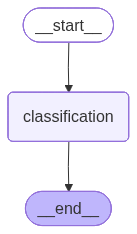

In [0]:
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
# Graph
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
from langgraph. graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition # Check if the model's output is a tool call
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver

# Graph
builder = StateGraph(AgentState)

# Nodes
builder.add_node("classification", classify_email)

# Define edges: these determine how the control flow moves
builder.add_edge(START, "classification")
builder.add_edge("classification", END)
memory = MemorySaver()
basic_email_classifier = builder.compile(checkpointer=memory)

display(Image(basic_email_classifier.get_graph(xray=True).draw_mermaid_png()))

In [0]:
## Testing
from pyspark.sql.functions import *
from langchain_core.messages import HumanMessage

# Extract test case from the dataframe with examples
config_ = {"configurable": {"thread_id": "1"}}
id_ = 1
example_row = df_example.filter(col("ID") == id_).first()
message_ = example_row.email_body

# Invoke the Agent
request = [
  HumanMessage(content = message_)
]
messages = basic_email_classifier.invoke({"messages": request}, config_)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Dear sir or madam, I would like to get my residence address updated to: v. bella 1, Milano (MI), Italia
================================== Ai Message ==================================


                Label: Profile Update

                Rationale: The customer explicitly asks to update their residence address, which is a change to their profile information.

                Next steps: 1) Verify the sender’s identity according to internal security procedures (e.g., authentication checks, security questions, or logged-in request). 2) Confirm that the new address format is complete and valid (street name/number, ZIP code, city, province, country). 3) Update the customer’s profile with the new address in the CRM/account system. 4) Send a confirmation email to the customer summarizing the updated address and the effective date of change. 5) If the address affects any open orders or shipments, review and 

## ReAct Version - 2
Evolving the previous architecture where the classification becomes a tool in a tool node of a ReAct agent.

**_Note_**: example 2 triggers an indefinite loop!

In [0]:
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
# Graph State
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages, AnyMessage
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

## Set up the agent state to concatenate messages in memory
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    label: str
    rationale: str
    next_steps: str

In [0]:
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
# Output Schema
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 

## Set up the output schema for the classification
from pydantic import BaseModel, Field
from typing import Literal

class LabelOutput(BaseModel):
  label: Literal[
      "Claim",
      "Profile Update",
      "Communication Unsubscription",
      "General Enquiry",
      "Spam",
      "Others"] = Field(
    description="Label assigned to the email",
    default="Others")
  rationale: str = Field(description="Reasoning behind the label choice")
  next_steps: str = Field(description="Recommended action items based on the customer's email")

In [0]:
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
# Base LLM
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 

from databricks_langchain import ChatDatabricks
model = ChatDatabricks(endpoint = "databricks-gpt-5-1", temperature=0) 

In [0]:
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
# Classification Tool
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 

from langchain_core.tools import tool
from langgraph.graph import MessagesState

# Classify through prompt
MODEL_SYSTEM_MESSAGE = ("""
    You are an email dispatcher assistant.
    Based on some contextual information, your tasks are: 
        (1) assign a label to each customer's email.
        (2) provide an summarized explanation of why you assigned such label.
        (3) recommend next steps, based on the context.

    Here are the available labels you can choose from, together with a description of when to use them:
    - `Claim`: the customer is formally requesting a complaint or a refund.
    - `Profile Update`: the customer is requesting to update or modify their profile information (such as address, ...).
    - `Communication Unsubscription`: the customer is requesting to stop receiving communications or newsletter about products, offers, etc.
    - `General Enquiry`: the customer is asking for general information about their orders, the company, shipping policies, return policies, reimbursement terms, etc.
    - `Spam`: the email is suspected being a spam email, not referring to any plausible customer's request and is not a plausible follow up to previous requests.
    - `Others`: in case the email cannot be related to any of the previous labels.

    Here is the contextual information.

    The body email sent by the customer:
    <email_body>
    {email_body}
    </email_body>

    Now classify the email, explain your reasoning and recommend next steps.
""")

## Classification definition
def classify_email(email_body: str) -> LabelOutput:
    
    """  Classify a customer email into one of the predefined labels, provide reasoning and next steps.  """
        
    # Pass data to the prompt
    full_prompt = MODEL_SYSTEM_MESSAGE.format(
        email_body=email_body,
    )

    # Invoke
    structured_model = model.with_structured_output(LabelOutput)
    result: LabelOutput = structured_model.invoke(
        [full_prompt]
    )
    
    return {
        "label": result.label,
        "rationale": result.rationale,
        "next_steps": result.next_steps,
        "tool_call_status": "Complete!"
    }

In [0]:
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
# Create Tool Binding
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
tools = [classify_email]
model_with_tools = model.bind_tools(tools, parallel_tool_calls=False)

In [0]:
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
# Reasoning Node (Assistant)
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 

from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="""
    You are a customer support assistant, tasked with classifying incoming emails and suggesting next actions to improve customer relationship.\n
    Use the available tools to perform the classification.\n
    If you feel unsure about the classification, DO NOT keep using the same tools but suggest asking for more information.\n
    Once you've obtained a valid label for the email STOP.""")

# Reasoning Node
def assistant(state: AgentState):
  result = model_with_tools.invoke([sys_msg] + state["messages"])
  return {"messages": [result]}

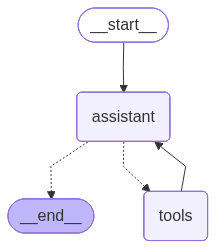

In [0]:
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 
# ReAct Graph
#### #### #### #### #### #### #### #### #### #### #### #### #### #### #### #### 

from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition # Check if the model's output is a tool call
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(AgentState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_email_classifier = builder.compile()

# Display the Graph
display(Image(react_email_classifier.get_graph().draw_mermaid_png()))

In [0]:
## Testing
from pyspark.sql.functions import *
from langchain_core.messages import HumanMessage
import mlflow

# Extract test case from the dataframe with examples
id_ = 2
config_ = {"configurable": {"thread_id": str(id_)}}
example_row = df_example.filter(col("ID") == id_).first()
message_ = example_row.email_body

# Invoke the Agent
mlflow.langchain.autolog()
with mlflow.start_run(run_name="React Email Classifier Test"):
  request = [
    HumanMessage(content = message_)
  ]
  messages = react_email_classifier.invoke({"messages": request}, config_)

  for m in messages['messages']:
      m.pretty_print()

Trace(trace_id=tr-ca0580dd6a6c766d18f1a96f5bc29bb2)

---------------------------------------------------------------------------
GraphRecursionError                       Traceback (most recent call last)
File <command-6361337296596387>, line 18
     14 with mlflow.start_run(run_name="React Email Classifier Test"):
     15   request = [
     16     HumanMessage(content = message_)
     17   ]
---> 18   messages = react_email_classifier.invoke({"messages": request}, config_)
     20   for m in messages['messages']:
     21       m.pretty_print()

File /local_disk0/.ephemeral_nfs/envs/pythonEnv-45574e1f-246a-4598-aee7-38a296dd28e6/lib/python3.12/site-packages/langgraph/pregel/main.py:3068, in Pregel.invoke(self, input, config, context, stream_mode, print_mode, output_keys, interrupt_before, interrupt_after, durability, **kwargs)
   3065 chunks: list[dict[str, Any] | Any] = []
   3066 interrupts: list[Interrupt] = []
-> 3068 for chunk in self.stream(
   3069     input,
   3070     config,
   3071     context=context,
   3072     stream_mode